# Imports and parameters

In [22]:
import os
from multiprocessing import Pool, cpu_count
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from astropy.wcs import WCS
import numpy as np
import scipy.ndimage as ndimage
import emcee
import corner
import matplotlib
import matplotlib.pyplot as plt

from minot.ClusterTools import map_tools
import minot

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [23]:
# Data
dat_dir = os.getenv('CTAPHYS_EDAT_DIR')
ymap_file = dat_dir+'/Planck/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits'

# Map parameters
FWHM_planck = 10.0*u.arcmin
map_fov = 6*u.deg
map_reso = 1*u.arcmin
FWHM2sigma = 1.0/(2.0*np.sqrt(2*np.log(2)))

# Analysis
Nmc = 500
reset_mcmc = True
mask_source = True
NFWHMmask = 3
src1 = SkyCoord("3h19m48.16s +41d30m42s", frame='icrs')              # NGC1275
src2 = SkyCoord(48.25948051*u.deg, +41.35073379*u.deg, frame='icrs') # as the peak of the map
yprof_reso = 5.0*u.arcmin

# Define the cluster model

In [24]:
cluster = minot.Cluster(name='Perseus', redshift=0.0179, M500=6.2e14*u.Msun, cosmology=cosmo, silent=True)
cluster.density_gas_model = {'name':'doublebeta', 'beta1':1.8, 'r_c1':80*u.kpc*0.73, 'n_01':3.9e-2*u.cm**-3*0.73**-0.5,
                             'beta2':0.87, 'r_c2':280*u.kpc*0.73, 'n_02':4.05e-3*u.cm**-3*0.73**-0.5}

radius = np.logspace(0,5,1000)*u.kpc
T_e = 7.0*(1+(radius.to_value('kpc')/(100.0*0.73))**3)/(2.3+(radius.to_value('kpc')/(100.0*0.73))**3)*u.keV
radius, n_e = cluster.get_density_gas_profile(radius)
P_e = n_e*T_e #* (1+(radius.to_value('kpc')/2000.0)**2)**-1
cluster.pressure_gas_model = {'name':'User', 'radius':radius, 'profile':P_e}

cluster.R_truncation = 10*cluster.R500
cluster.coord = SkyCoord("3h19m47.2s +41d30m47s", frame='icrs')
cluster.output_dir = os.getenv('CTAPHYS_OUT_DIR')+'Perseus_KSP_calibration'
cluster.map_fov = map_fov
cluster.map_reso = map_reso

Text(0,0.5,'entropy (keV cm$^{-2}$)')

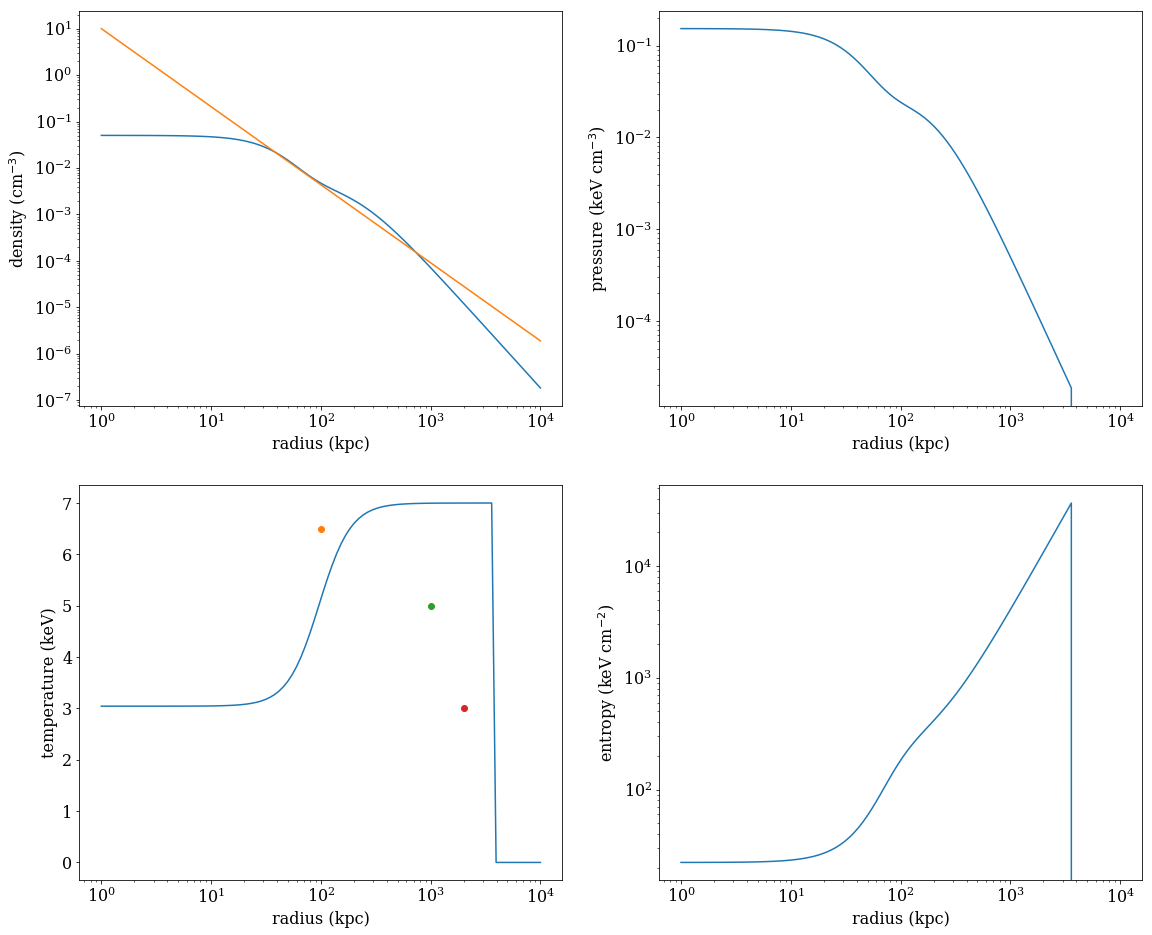

In [25]:
fig = plt.figure(0, figsize=(18, 16))
ax = plt.subplot(221)
r,n = cluster.get_density_gas_profile()
plt.loglog(r,n)
plt.loglog(r,10*r**-1.68, label='slope at ~1Mpc, Simionescu et al. (2011)')
plt.xlabel('radius (kpc)')
plt.ylabel('density (cm$^{-3}$)')

ax = plt.subplot(222)
r,p = cluster.get_pressure_gas_profile()
plt.loglog(r,p)
plt.xlabel('radius (kpc)')
plt.ylabel('pressure (keV cm$^{-3}$)')

ax = plt.subplot(223)
r,t = cluster.get_temperature_gas_profile()
plt.plot(r,t)
plt.plot([100], [6.5], marker='o')
plt.plot([1000], [5], marker='o')
plt.plot([2000], [3], marker='o')
plt.xscale('log')
plt.xlabel('radius (kpc)')
plt.ylabel('temperature (keV)')

ax = plt.subplot(224)
r,k = cluster.get_entropy_gas_profile()
plt.loglog(r,k)
plt.xlabel('radius (kpc)')
plt.ylabel('entropy (keV cm$^{-2}$)')

# Extract the Planck map

### Raw map

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
85.7650881953 94.2349118047 -4.23491180468 4.23491180468
The interval between parallels is 1 deg 0.00'.
The interval between meridians is 1 deg 0.00'.


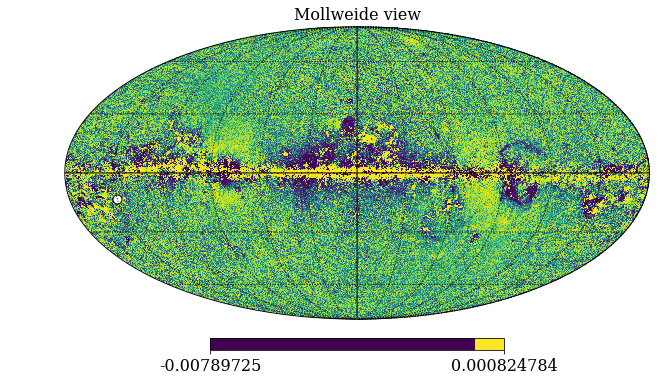

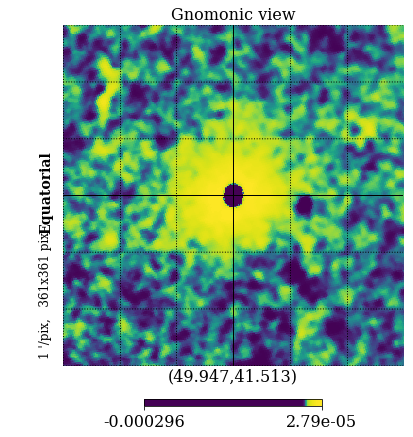

In [26]:
ymap_data, header = map_tools.roi_extract_healpix(ymap_file, cluster.coord.ra.value, cluster.coord.dec.value, 
                                                  cluster.map_reso.to_value('deg'), 
                                                  [cluster.map_fov[0].to_value('deg'), cluster.map_fov[1].to_value('deg')],
                                                  visu=True)
cluster.map_header = header

### Error map and mask

Text(0.5,1,'Source mask')

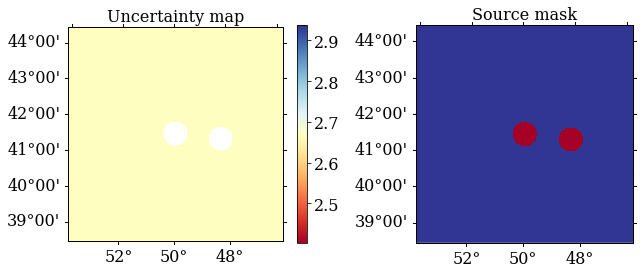

In [27]:
# First guess for the error
ymap_err = ymap_data*0 + np.std(ymap_data)

# Flag signal
for i in [1,2,3,4,5,6]: 
    ymap_err = ymap_data*0 + np.std(ymap_data[np.abs(ymap_data/ymap_err) < 3])
mask = ymap_err*0+1
    
# Mask central source
ramap, decmap = map_tools.get_radec_map(header)
# Central
if mask_source:
    distance = map_tools.greatcircle(ramap, decmap, src1.ra.to_value('deg'), src1.dec.to_value('deg'))
    ymap_err[distance<2*FWHM_planck.to_value('deg')] = np.nan
    mask[distance<2*FWHM_planck.to_value('deg')]     = 0
    
# Secondary
distance = map_tools.greatcircle(ramap, decmap, src2.ra.to_value('deg'), src2.dec.to_value('deg'))
ymap_err[distance<2*FWHM_planck.to_value('deg')] = np.nan
mask[distance<2*FWHM_planck.to_value('deg')]     = 0

# Show the map
fig = plt.figure(0, figsize=(10, 4))
ax = plt.subplot(121, projection=WCS(header))
plt.imshow(1e6*ymap_err, origin='lower', cmap='RdYlBu')
plt.colorbar()
plt.title('Uncertainty map')

ax = plt.subplot(122, projection=WCS(header))
plt.imshow(mask, origin='lower', cmap='RdYlBu')
plt.title('Source mask')

# Model - data comparison

In [28]:
ymap_model = cluster.get_sz_map(Compton_only=True)
ymap_model = ndimage.gaussian_filter(ymap_model, sigma=FWHM2sigma*(FWHM_planck/map_reso).to_value(''), order=0)

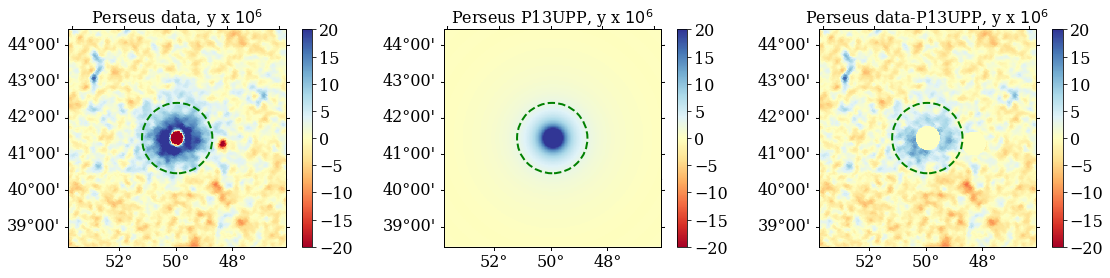

In [29]:
rad = cluster.theta500.to_value('deg')

fig = plt.figure(0, figsize=(18, 4))
ax = plt.subplot(131, projection=WCS(header))
plt.imshow(1e6*ymap_data, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),2*rad/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad,linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(cluster.name+' data, y x $10^6$')
ax = plt.subplot(132, projection=WCS(header))
plt.imshow(1e6*ymap_model, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),2*rad/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad,linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(cluster.name+' P13UPP, y x $10^6$')
ax = plt.subplot(133, projection=WCS(header))
plt.imshow(1e6*(ymap_data-ymap_model)*mask, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),2*rad/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad,linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title(cluster.name+' data-P13UPP, y x $10^6$')
plt.savefig(cluster.output_dir+'/ResultsTh_UPP_residual')

### Residual profiles

In [9]:
yprof_rad, yprof_data, yprof_err = map_tools.radial_profile_sb(ymap_data, 
                                                               (cluster.coord.ra.value, cluster.coord.dec.value), 
                                                               stddev=ymap_err,
                                                               header=header,
                                                               binsize=yprof_reso.to_value('deg'))
yprof_rad, yprof_mod, bid = map_tools.radial_profile_sb(ymap_model, 
                                                        (cluster.coord.ra.value, cluster.coord.dec.value), 
                                                        stddev=ymap_model*0+1,
                                                        header=header,
                                                        binsize=yprof_reso.to_value('deg'))

/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/minot/ClusterTools/map_tools.py:575: RuntimeWarning: invalid value encountered in greater
  w_bin_val = (stddev > 0) * (np.isnan(stddev) == False) * (np.isnan(image) == False)


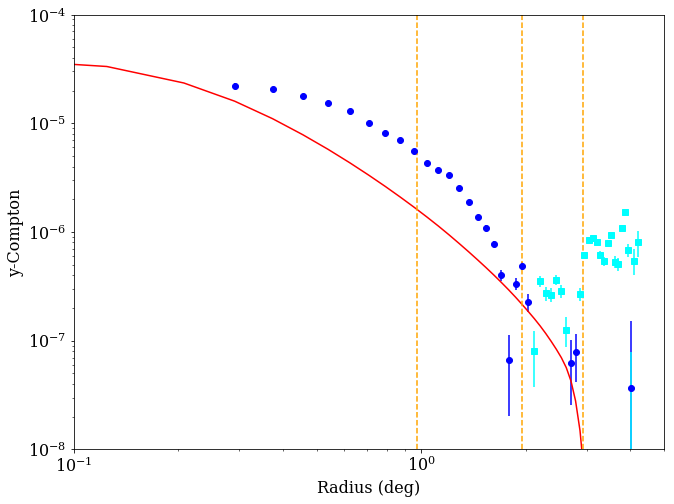

In [10]:
plt.figure(figsize=(10,8))
plt.errorbar(yprof_rad, yprof_data, yprof_err, marker='o', linestyle='', color='blue')
plt.errorbar(yprof_rad, -yprof_data, yprof_err, marker='s', linestyle='', color='cyan')
plt.plot(yprof_rad, yprof_mod, linestyle='-', color='red')
plt.plot([1*cluster.theta500.to_value('deg'),1*cluster.theta500.to_value('deg')], [0,1], linestyle='--', color='orange')
plt.plot([2*cluster.theta500.to_value('deg'),2*cluster.theta500.to_value('deg')], [0,1], linestyle='--', color='orange')
plt.plot([3*cluster.theta500.to_value('deg'),3*cluster.theta500.to_value('deg')], [0,1], linestyle='--', color='orange')
plt.ylim(1e-8, 1e-4)
plt.xlim(1e-1, 5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (deg)')
plt.ylabel('y-Compton')
plt.savefig(cluster.output_dir+'/ResultsTh_compton'+'_mask'+str(mask_source))

### Pressure profile

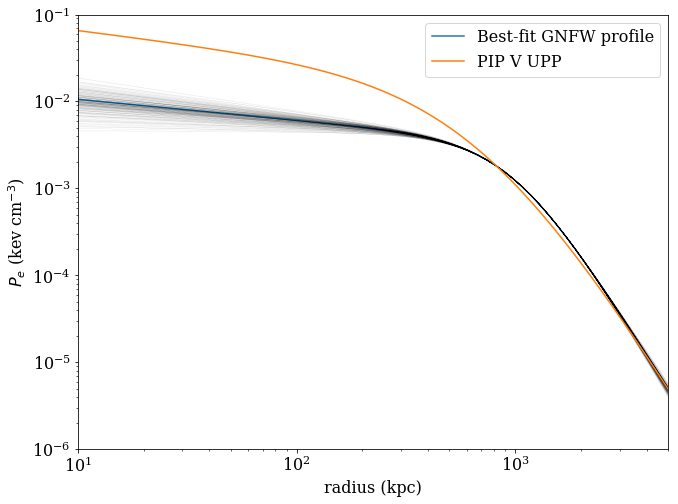

In [20]:
# How to derive the Pressure and Compton parameter profile
cluster.pressure_gas_model = {'name':'GNFW', 'P_0':param_best[0]*u.keV/u.cm**3, 
                              'r_p':param_best[1]*u.kpc,
                              'a':param_best[2], 
                              'b':param_best[3], 
                              'c':param_best[4]}
plt.figure(figsize=(10,8))
r, p_r = cluster.get_pressure_gas_profile()
plt.loglog(r, p_r, label='Best-fit GNFW profile')
for imc in range(Nmc):
    cluster.pressure_gas_model = {'name':'GNFW', 'P_0':param_MC[imc,0]*u.keV/u.cm**3, 
                                  'r_p':param_MC[imc,1]*u.kpc,
                                  'a':param_MC[imc,2], 
                                  'b':param_MC[imc,3], 
                                  'c':param_MC[imc,4]}
    r, p_r = cluster.get_pressure_gas_profile()
    plt.loglog(r, p_r, linestyle='-', linewidth=0.1, color='k', alpha=0.1)
cluster.set_pressure_gas_gNFW_param('P13UPP')
r, p_r = cluster.get_pressure_gas_profile()
plt.loglog(r, p_r, label='PIP V UPP')
plt.xlabel('radius (kpc)')
plt.ylabel('$P_e$ (kev cm$^{-3}$)')
plt.legend()
plt.xlim(10,5000)
plt.ylim(1e-6,1e-1)
plt.savefig(cluster.output_dir+'/ResultsTh_gas_pressure'+'_mask'+str(mask_source))

### Uth500

In [21]:
U_th500 = []
for imc in range(Nmc):
    cluster.pressure_gas_model = {'name':'GNFW', 'P_0':param_MC[imc,0]*u.keV/u.cm**3, 
                                  'r_p':param_MC[imc,1]*u.kpc,
                                  'a':param_MC[imc,2], 
                                  'b':param_MC[imc,3], 
                                  'c':param_MC[imc,4]}
    U_th500.append(cluster.get_thermal_energy_profile(radius=cluster.R500)[1][0].to_value('erg'))

/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


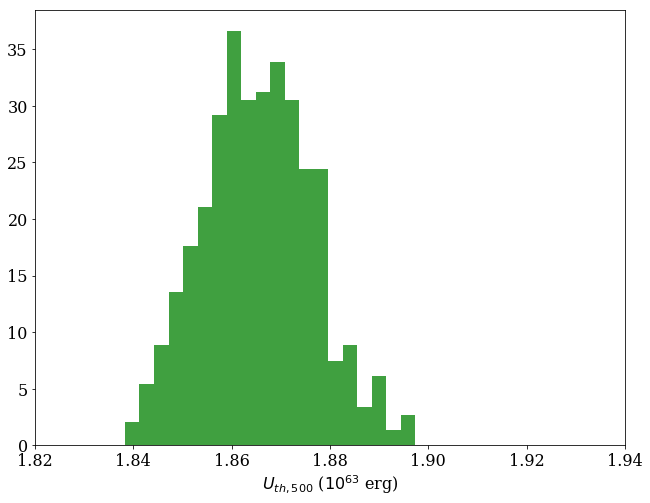

In [22]:
plt.figure(figsize=(10,8))
n,b,p = plt.hist(np.array(U_th500)/1e63, 20, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('$U_{th,500}$ ($10^{63}$ erg)')
plt.xlim(1.82,1.94)
plt.savefig(cluster.output_dir+'/ResultsTh_gas_uth500'+'_mask'+str(mask_source))

In [23]:
cluster.set_pressure_gas_gNFW_param('P13UPP')
print('P13 UPP: ',cluster.get_thermal_energy_profile(radius=cluster.R500)[1][0])

('P13 UPP: ', <Quantity 2.20710505e+63 erg>)


### Implication for the temperature and other thermodynamic quantities

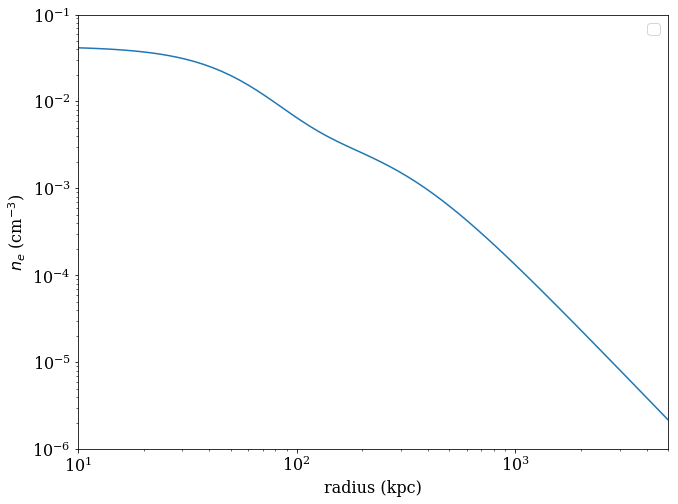

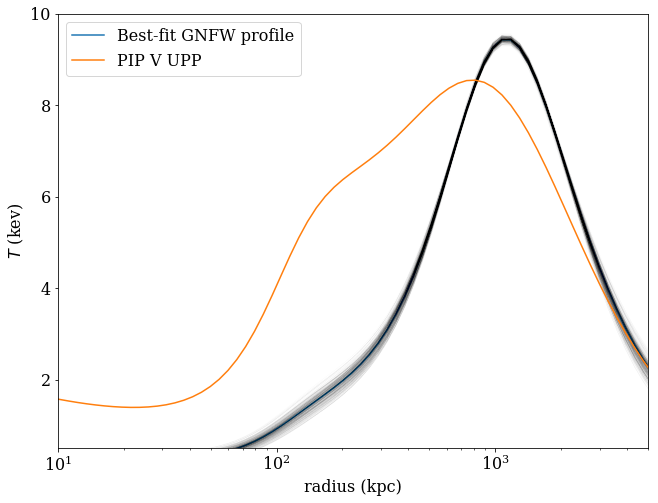

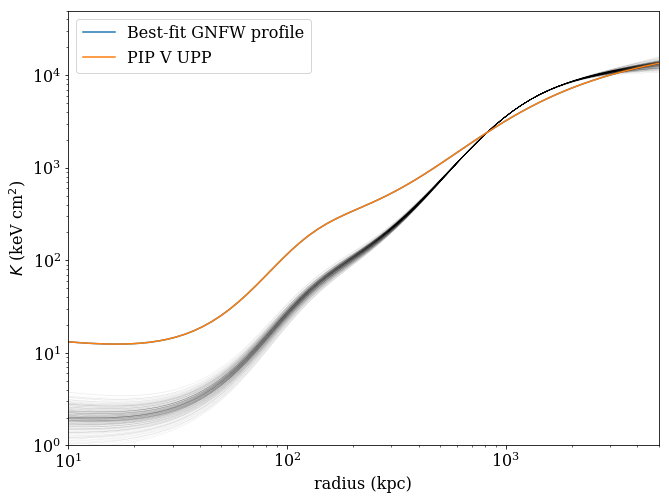

In [24]:
cluster.pressure_gas_model = {'name':'GNFW', 'P_0':param_best[0]*u.keV/u.cm**3, 
                              'r_p':param_best[1]*u.kpc,
                              'a':param_best[2], 
                              'b':param_best[3], 
                              'c':param_best[4]}

plt.figure(figsize=(10,8))
r, n_r = cluster.get_density_gas_profile()
plt.loglog(r, n_r)
plt.xlabel('radius (kpc)')
plt.ylabel('$n_e$ (cm$^{-3}$)')
plt.legend()
plt.xlim(10,5000)
plt.ylim(0.000001,0.1)
plt.savefig(cluster.output_dir+'/ResultsTh_gas_density'+'_mask'+str(mask_source))
plt.figure(figsize=(10,8))
r, t_r = cluster.get_temperature_gas_profile()
plt.plot(r, t_r, label='Best-fit GNFW profile')
for imc in range(Nmc):
    cluster.pressure_gas_model = {'name':'GNFW', 'P_0':param_MC[imc,0]*u.keV/u.cm**3, 
                                  'r_p':param_MC[imc,1]*u.kpc,
                                  'a':param_MC[imc,2], 
                                  'b':param_MC[imc,3], 
                                  'c':param_MC[imc,4]}
    r, t_r = cluster.get_temperature_gas_profile()
    plt.plot(r, t_r, linestyle='-', linewidth=0.1, color='k', alpha=0.1)
cluster.set_pressure_gas_gNFW_param('P13UPP')
r, t_r = cluster.get_temperature_gas_profile()
plt.plot(r, t_r, label='PIP V UPP')
plt.xscale('log')
plt.xlabel('radius (kpc)')
plt.ylabel('$T$ (kev)')
plt.legend()
plt.xlim(10,5000)
plt.ylim(0.5,10)
plt.savefig(cluster.output_dir+'/ResultsTh_gas_temperature'+'_mask'+str(mask_source))

plt.figure(figsize=(10,8))
r, k_r = cluster.get_entropy_gas_profile()
plt.loglog(r, k_r, label='Best-fit GNFW profile')
for imc in range(Nmc):
    cluster.pressure_gas_model = {'name':'GNFW', 'P_0':param_MC[imc,0]*u.keV/u.cm**3, 
                                  'r_p':param_MC[imc,1]*u.kpc,
                                  'a':param_MC[imc,2], 
                                  'b':param_MC[imc,3], 
                                  'c':param_MC[imc,4]}
    r, k_r = cluster.get_entropy_gas_profile()
    plt.loglog(r, k_r, linestyle='-', linewidth=0.1, color='k', alpha=0.1)
cluster.set_pressure_gas_gNFW_param('P13UPP')
r, k_r = cluster.get_entropy_gas_profile()
plt.loglog(r, k_r, label='PIP V UPP')
plt.xlabel('radius (kpc)')
plt.ylabel('$K$ (keV cm$^{2}$)')
plt.legend()
plt.xlim(10,5000)
plt.ylim(1,50000)
plt.savefig(cluster.output_dir+'/ResultsTh_gas_entropy'+'_mask'+str(mask_source))